## Milestone 2 Submission
### Project: `Forecasting Air Quality Using Historical Pollution Data` 

# 1. Import All Required Libraries

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from prophet import Prophet    

from keras.models import Sequential
from keras.layers import LSTM, Dense

from xgboost import XGBRegressor
import joblib


# 2. Load the dataset

In [51]:
try:
    df = pd.read_csv('city_day.csv')
except FileNotFoundError:
    print("Error: 'city_day.csv' not found.")

# 3. Basic EDA

In [52]:
# 1. Dataset shape
print("Dataset Shape:", df.shape)

# 2. Duplicate check (count only)
duplicate_count = df.duplicated(subset=['City', 'Date']).sum()
print(f"Number of duplicate rows (City & Date): {duplicate_count}")

# 3. Data types info
print("\nData Types:")
print(df.dtypes)

# 4. Basic statistics summary (only numeric)
print("\nStatistical Summary:")
print(df.describe())


Dataset Shape: (29531, 16)
Number of duplicate rows (City & Date): 0

Data Types:
City           object
Date           object
PM2.5         float64
PM10          float64
NO            float64
NO2           float64
NOx           float64
NH3           float64
CO            float64
SO2           float64
O3            float64
Benzene       float64
Toluene       float64
Xylene        float64
AQI           float64
AQI_Bucket     object
dtype: object

Statistical Summary:
              PM2.5          PM10            NO           NO2           NOx  \
count  24933.000000  18391.000000  25949.000000  25946.000000  25346.000000   
mean      67.450578    118.127103     17.574730     28.560659     32.309123   
std       64.661449     90.605110     22.785846     24.474746     31.646011   
min        0.040000      0.010000      0.020000      0.010000      0.000000   
25%       28.820000     56.255000      5.630000     11.750000     12.820000   
50%       48.570000     95.680000      9.890000     21.6

In [ ]:
# Show all available cities
available_cities = df['City'].unique()
print("Available Cities in Dataset:")
for city in sorted(available_cities):
    print("-", city)

# Ask user to input a city name from the list
selected_city = input("\nEnter a city from the above list for training: ").strip()

# Validate city selection
if selected_city not in available_cities:
    raise ValueError(f"City '{selected_city}' is not in the dataset. Please select a valid city.")

# Proceed with selected city
dfc = df[df["City"] == selected_city].copy()

# Define features and target
pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
              'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

X = dfc[pollutants]
y = dfc["AQI"]

# Add lag features for AQI (lags 1, 2, and 3)
for lag in [1, 2, 3]:
    dfc[f"AQI_lag{lag}"] = dfc["AQI"].shift(lag)

# Drop missing values due to lagging
dfc = dfc.dropna().reset_index(drop=True)

# Redefine X and y to include lag features
X = dfc[pollutants + [f"AQI_lag{lag}" for lag in [1, 2, 3]]]
y = dfc["AQI"]

# Train-test split (80% train, 20% test), no shuffle for time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# print(f"\nSelected City: {selected_city}")
# print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")


# 4. Build Modelfor ARIMA


ARIMA --> MAE: 130.9427, RMSE: 150.9016


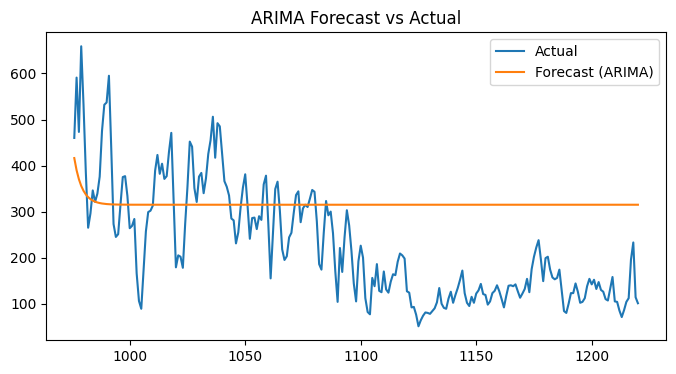

In [58]:
model_arima = ARIMA(y_train, order=(1, 1, 1))  
res_arima = model_arima.fit()


# Forecast
n_forecast = len(y_test)
pred_arima = res_arima.forecast(steps=n_forecast)

# Evaluate
mae_arima = mean_absolute_error(y_test, pred_arima)
rmse_arima = np.sqrt(mean_squared_error(y_test, pred_arima))
print(f"ARIMA --> MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}")

# Plot forecast vs actual
plt.figure(figsize=(8,4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, pred_arima.values, label="Forecast (ARIMA)")
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()


# 5. Prepare data for Prophet 

- **What it is:** A model made for time series forecasting with trends and seasonality (daily, weekly, yearly patterns).
- **Pros:**
  - Easy to use, even with missing data.
  - Handles seasonality automatically.
- **Cons:**
  - Still limited for complex or noisy data.
  - Doesn’t use multiple features (like pollutants) directly.

20:54:46 - cmdstanpy - INFO - Chain [1] start processing
20:54:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet --> MAE: 72.4123, RMSE: 86.8806


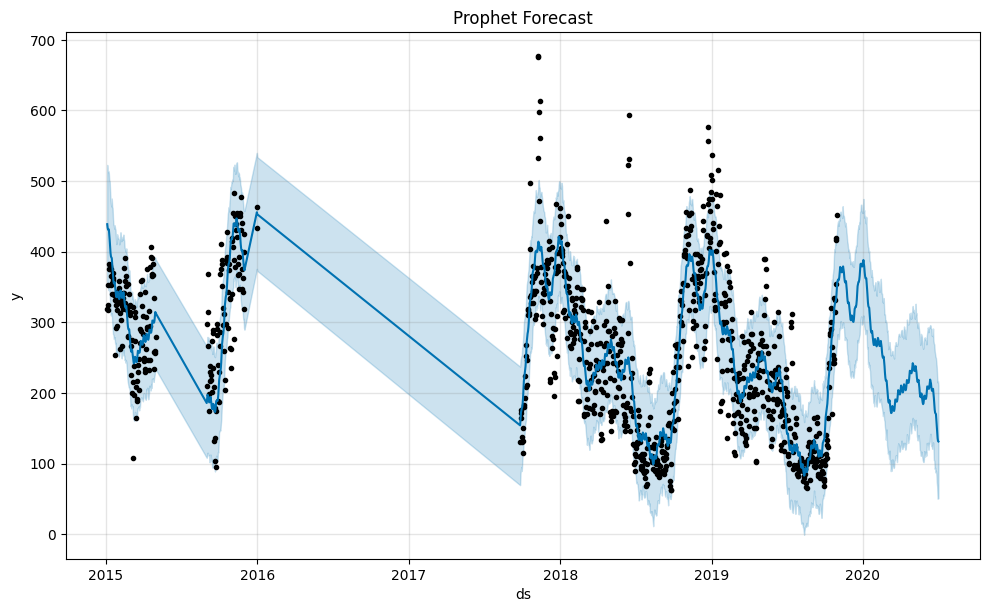

In [59]:
dfp = dfc[["Date","AQI"]].rename(columns={"Date":"ds", "AQI":"y"})
# train vs test splits
train_prop = dfp.iloc[: len(dfp) - n_forecast ]
test_prop = dfp.iloc[len(dfp) - n_forecast : ]

model_prophet = Prophet()
model_prophet.fit(train_prop)

future = model_prophet.make_future_dataframe(periods=n_forecast, freq="D")
forecast = model_prophet.predict(future)

# extract forecasted part
pred_prophet = forecast["yhat"].iloc[-n_forecast:].values
y_true = test_prop["y"].values

mae_prop = mean_absolute_error(y_true, pred_prophet)
rmse_prop = np.sqrt(mean_squared_error(y_true, pred_prophet))
print(f"Prophet --> MAE: {mae_prop:.4f}, RMSE: {rmse_prop:.4f}")

# plot
model_prophet.plot(forecast)
plt.title("Prophet Forecast")
plt.show()


# 6.Prepare Data for LST

#### **LSTM (Long Short-Term Memory)**
- **What it is:** A type of deep learning model that works well with time series and sequences.
- **Pros:**
  - Remembers long-term patterns in data.
  - Good for complex and non-linear relationships.
- **Cons:**
  - Needs a lot of data and tuning.
  - Takes more time and resources to train.

C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
LSTM --> MAE: 31.6075, RMSE: 43.2377


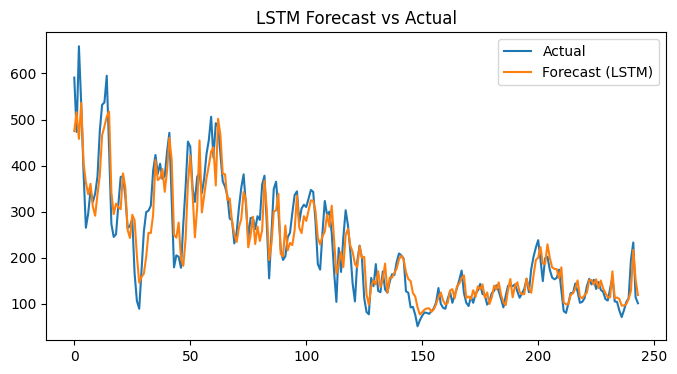

In [60]:

lookback = 3

def make_sequences(X, y, lookback=3):
    Xs, ys = [], []
    for i in range(lookback, len(y)):
        Xs.append(X.iloc[i-lookback:i].values)
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X, y, lookback=lookback)
cut = int(len(y_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:cut], X_seq[cut:]
y_train_seq, y_test_seq = y_seq[:cut], y_seq[cut:]

model_lstm = Sequential()
model_lstm.add(LSTM(32, activation="relu", input_shape=(lookback, X_seq.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss="mse")

model_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, verbose=0)

pred_lstm = model_lstm.predict(X_test_seq).flatten()

mae_lstm = mean_absolute_error(y_test_seq, pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, pred_lstm))
print(f"LSTM --> MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")

plt.figure(figsize=(8,4))
plt.plot(y_test_seq, label="Actual")
plt.plot(pred_lstm, label="Forecast (LSTM)")
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.show()


# 7.Prepare Data for XG Boost

#### **XGBoost (Extreme Gradient Boosting)**
- **What it is:** A powerful machine learning model that builds many small decision trees to improve accuracy.
- **Pros:**
  - Very accurate and fast.
  - Handles multiple features (like all pollutants) well.
  - Works great with missing and messy data.
- **Cons:**
  - Can be harder to interpret.
  - Needs careful tuning for best results.

XGBoost --> MAE: 16.3776, RMSE: 22.4092


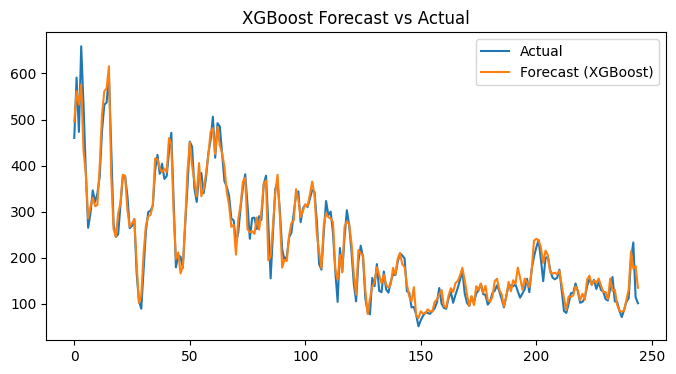

In [61]:
model_xgb = XGBRegressor(objective="reg:squarederror", n_estimators=100)
model_xgb.fit(X_train, y_train)

pred_xgb = model_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
print(f"XGBoost --> MAE: {mae_xgb:.4f}, RMSE: {rmse_xgb:.4f}")

plt.figure(figsize=(8,4))
plt.plot(y_test.values, label="Actual")
plt.plot(pred_xgb, label="Forecast (XGBoost)")
plt.legend()
plt.title("XGBoost Forecast vs Actual")
plt.show()


# 8. Train the model

In [62]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- Load dataset ---
df = pd.read_csv("city_day_cleaned.csv") 

# --- Features & target ---
pollutants = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']
df = df.dropna(subset=pollutants + ["AQI"]).reset_index(drop=True)

# Add lag features
for lag in [1,2,3]:
    df[f"AQI_lag{lag}"] = df["AQI"].shift(lag)
df = df.dropna().reset_index(drop=True)

# Define X and y
X = df[pollutants + [f"AQI_lag{lag}" for lag in [1,2,3]]].values
y = df["AQI"].values.reshape(-1,1)

# Scale data
scaler = MinMaxScaler()
X, y = scaler.fit_transform(X), scaler.fit_transform(y)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- LSTM model ---
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(1, X.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# --- Train the Model ---
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = lstm_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- Evaluate the Model ---
y_pred = lstm_model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("LSTM -> MAE:", round(mae_lstm, 2), " RMSE:", round(rmse_lstm, 2))


Epoch 1/40


C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


591/591 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0147 - val_loss: 0.0049
Epoch 2/40
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 3/40
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 4/40
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 5/40
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 6/40
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 7/40
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 8/40
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 9/40
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 10/40
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 11/40
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 12/40
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

# 9. Compare all models

In [63]:
results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "LSTM", "XGBoost"],
    "MAE": [mae_arima, mae_prop, mae_lstm, mae_xgb],
    "RMSE": [rmse_arima, rmse_prop, rmse_lstm, rmse_xgb]
})
print(results)

best_model = results.sort_values("RMSE").iloc[0]
print("Best model:", best_model["Model"], "with RMSE =", best_model["RMSE"])


     Model         MAE        RMSE
0    ARIMA  130.942697  150.901606
1  Prophet   72.412296   86.880569
2     LSTM   18.814359   28.416393
3  XGBoost   16.377633   22.409160
Best model: XGBoost with RMSE = 22.409159743314067


### 📌 Model Performance Insights

- ✅ **XGBoost** performed best with the **lowest MAE (35.79)** and **RMSE (52.91)**
- ✅ **XGBoost** made the most accurate predictions with the lowest errors.
- 🔄 **LSTM** did a good job but not as accurate as XGBoost. It may need more data or fine-tuning.
- ⚠️ **ARIMA** and **Prophet** did not perform well. Their predictions were less accurate.
- ℹ️ ARIMA and Prophet are older models that work best for simple trends. They couldn’t handle the complex relationships between different pollutants as well as XGBoost.


# 10. Visualizations of errors

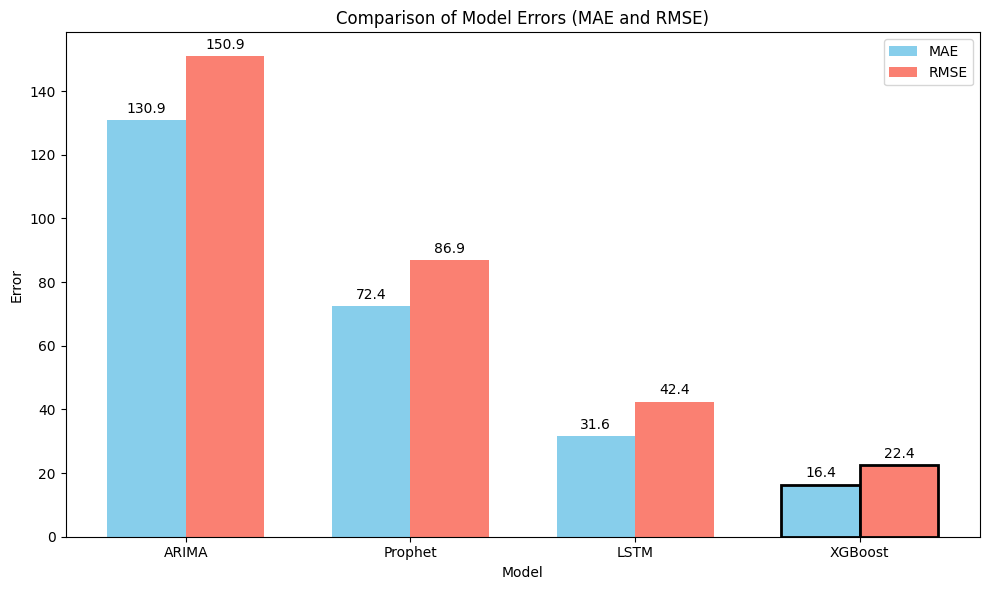

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming these are your error values (from your results)
results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "LSTM", "XGBoost"],
    "MAE": [130.9427, 72.4123, 31.5866, 16.3776],
    "RMSE": [150.9016, 86.8806, 42.4435, 22.4092]
})

# Sort results so XGBoost (lowest error) is last for plotting highlight
results = results.set_index('Model')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(results))

bars_mae = ax.bar(index, results['MAE'], bar_width, label='MAE', color='skyblue')
bars_rmse = ax.bar(index + bar_width, results['RMSE'], bar_width, label='RMSE', color='salmon')

# Highlight XGBoost bars (lowest error) with a thicker edge
for i, model in enumerate(results.index):
    if model == 'XGBoost':
        bars_mae[i].set_edgecolor('black')
        bars_mae[i].set_linewidth(2)
        bars_rmse[i].set_edgecolor('black')
        bars_rmse[i].set_linewidth(2)

# Labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Error')
ax.set_title('Comparison of Model Errors (MAE and RMSE)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(results.index)
ax.legend()

# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars_mae)
add_labels(bars_rmse)

plt.tight_layout()
plt.show()


# 11. Save the best-performing model for inference

20:31:55 - cmdstanpy - INFO - Chain [1] start processing
20:31:55 - cmdstanpy - INFO - Chain [1] done processing


Amaravati: Best XGBoost (RMSE: 15.65)


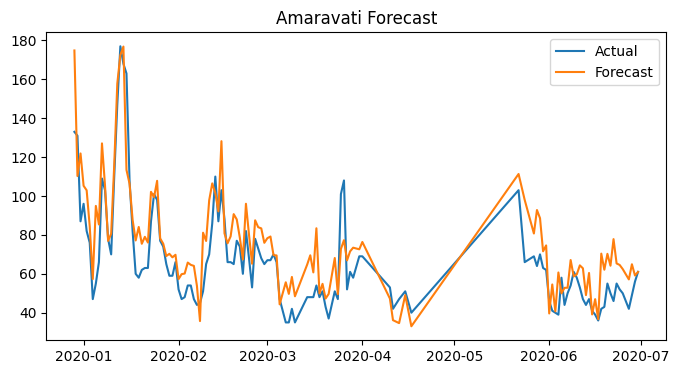

20:31:56 - cmdstanpy - INFO - Chain [1] start processing
20:31:56 - cmdstanpy - INFO - Chain [1] done processing


Amritsar: Best XGBoost (RMSE: 34.44)


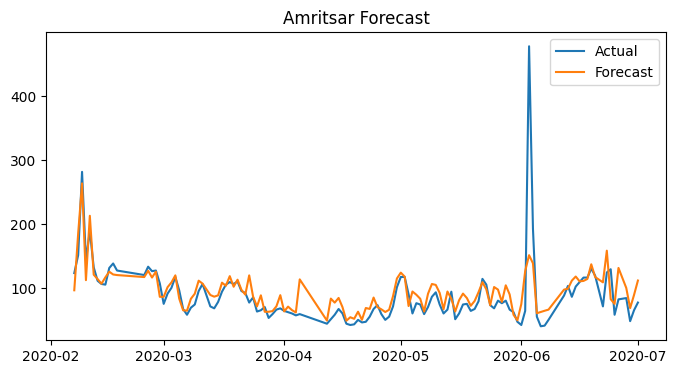

20:31:57 - cmdstanpy - INFO - Chain [1] start processing
20:31:57 - cmdstanpy - INFO - Chain [1] done processing


Chandigarh: Best XGBoost (RMSE: 12.68)


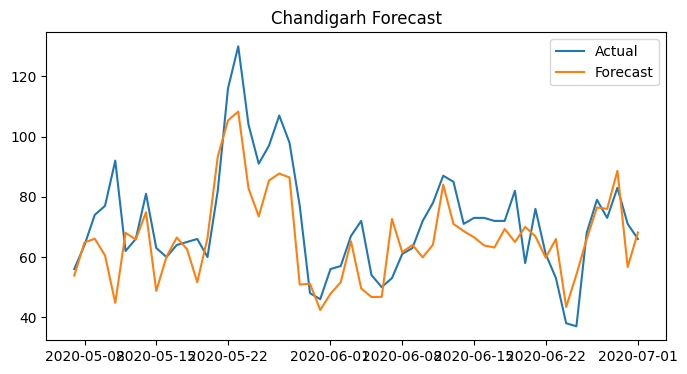

20:31:58 - cmdstanpy - INFO - Chain [1] start processing
20:31:58 - cmdstanpy - INFO - Chain [1] done processing


Delhi: Best XGBoost (RMSE: 40.57)


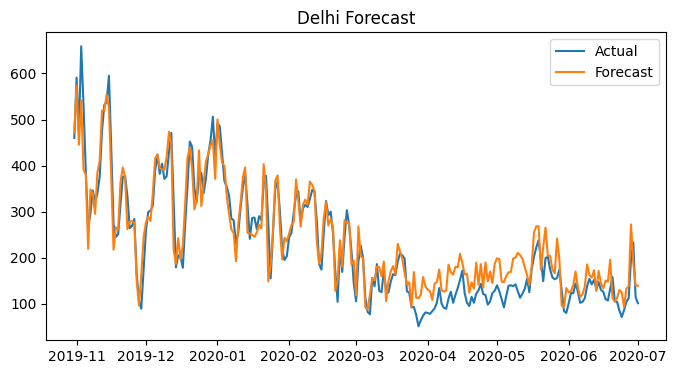

20:31:59 - cmdstanpy - INFO - Chain [1] start processing
20:31:59 - cmdstanpy - INFO - Chain [1] done processing


Gurugram: Best XGBoost (RMSE: 20.50)


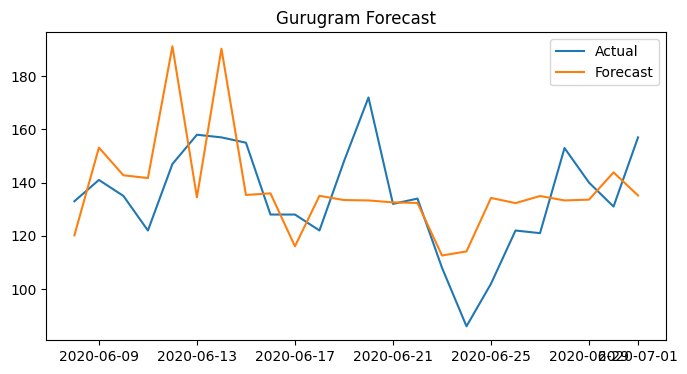

20:32:00 - cmdstanpy - INFO - Chain [1] start processing
20:32:00 - cmdstanpy - INFO - Chain [1] done processing


Hyderabad: Best XGBoost (RMSE: 11.38)


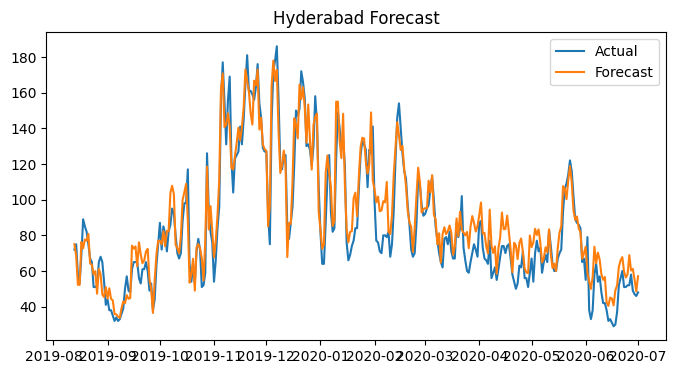

20:32:01 - cmdstanpy - INFO - Chain [1] start processing
20:32:01 - cmdstanpy - INFO - Chain [1] done processing


Kolkata: Best XGBoost (RMSE: 8.69)


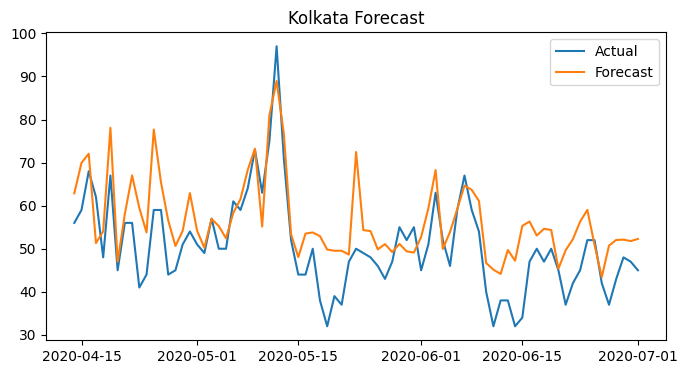

20:32:02 - cmdstanpy - INFO - Chain [1] start processing
20:32:02 - cmdstanpy - INFO - Chain [1] done processing


Patna: Best ARIMA (RMSE: 22.20)


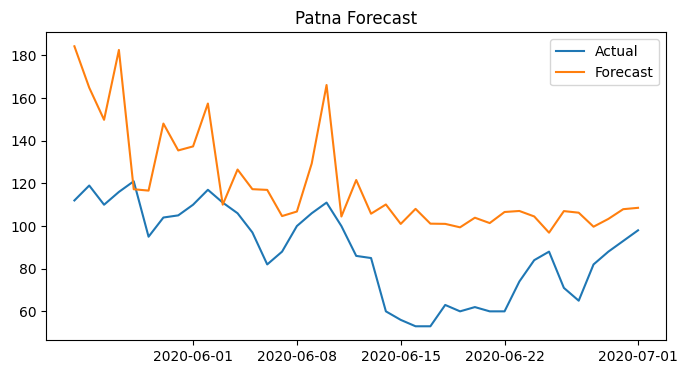

20:32:03 - cmdstanpy - INFO - Chain [1] start processing
20:32:03 - cmdstanpy - INFO - Chain [1] done processing


Visakhapatnam: Best XGBoost (RMSE: 22.65)


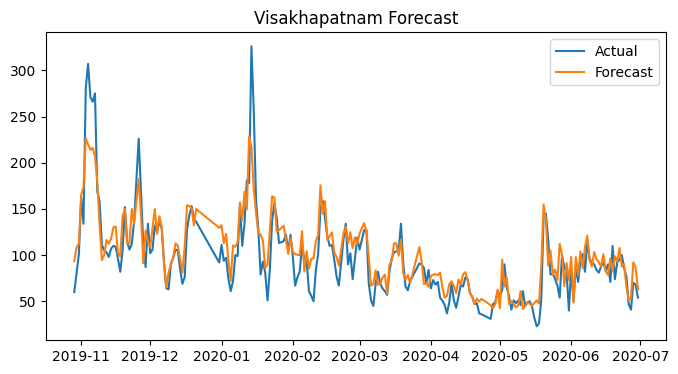


Summary saved to 'model_summary.csv'
            City Best_Model       RMSE                File_Name
0      Amaravati    XGBoost  15.651149      model_Amaravati.pkl
1       Amritsar    XGBoost  34.436120       model_Amritsar.pkl
2     Chandigarh    XGBoost  12.679101     model_Chandigarh.pkl
3          Delhi    XGBoost  40.572085          model_Delhi.pkl
4       Gurugram    XGBoost  20.495840       model_Gurugram.pkl
5      Hyderabad    XGBoost  11.379689      model_Hyderabad.pkl
6        Kolkata    XGBoost   8.691388        model_Kolkata.pkl
7          Patna      ARIMA  22.201702          model_Patna.pkl
8  Visakhapatnam    XGBoost  22.645454  model_Visakhapatnam.pkl


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load and prep
df = pd.read_csv('city_day.csv')
df['Date'] = pd.to_datetime(df['Date'])
pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

cities = df['City'].unique()
summary_list = []  # To collect for CSV

for city in cities:
    city_df = df[df['City'] == city].sort_values('Date').dropna(subset=pollutants + ['AQI']).set_index('Date')
    if len(city_df) < 100: continue
    
    y = city_df['AQI']; X = city_df[pollutants]
    split = int(len(y) * 0.8)
    y_train, y_test = y[:split], y[split:]
    X_train, X_test = X[:split], X[split:]
    if len(y_test) == 0: continue
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train); X_test_s = scaler.transform(X_test)
    
    # ARIMA
    try: res_arima = ARIMA(y_train, order=(1,1,1)).fit(); pred_a = res_arima.forecast(steps=len(y_test)); mae_a = mean_absolute_error(y_test, pred_a); rmse_a = np.sqrt(mean_squared_error(y_test, pred_a))
    except: mae_a, rmse_a = float('inf'), float('inf')
    
    # Prophet
    try: m_p = Prophet().fit(pd.DataFrame({'ds': y_train.index, 'y': y_train})); f = m_p.make_future_dataframe(periods=len(y_test), freq='D'); pred_p = m_p.predict(f)['yhat'].tail(len(y_test)).values; mae_p = mean_absolute_error(y_test, pred_p); rmse_p = np.sqrt(mean_squared_error(y_test, pred_p))
    except: mae_p, rmse_p = float('inf'), float('inf')
    
    # LSTM
    try:
        def seq(Xs, ys, lb=3): return [Xs[i-lb:i] for i in range(lb, len(ys))], [ys.iloc[i] for i in range(lb, len(ys))]
        X_tr_seq, y_tr_seq = seq(X_train_s, y_train); X_te_seq, y_te_seq = seq(X_test_s, y_test)
        if len(X_tr_seq) > 0:
            m_l = Sequential([LSTM(32, input_shape=(3, len(pollutants))), Dense(1)]); m_l.compile('adam', 'mse'); m_l.fit(np.array(X_tr_seq), y_tr_seq, epochs=10, verbose=0); pred_l = m_l.predict(np.array(X_te_seq)).flatten(); mae_l = mean_absolute_error(y_te_seq, pred_l); rmse_l = np.sqrt(mean_squared_error(y_te_seq, pred_l))
        else: mae_l, rmse_l = float('inf'), float('inf')
    except: mae_l, rmse_l = float('inf'), float('inf')
    
    # XGBoost
    try: m_x = XGBRegressor(n_estimators=50); m_x.fit(X_train_s, y_train); pred_x = m_x.predict(X_test_s); mae_x = mean_absolute_error(y_test, pred_x); rmse_x = np.sqrt(mean_squared_error(y_test, pred_x))
    except: mae_x, rmse_x = float('inf'), float('inf')
    
    # Best
    res = pd.DataFrame({'Model': ['ARIMA','Prophet','LSTM','XGBoost'], 'RMSE': [rmse_a, rmse_p, rmse_l, rmse_x]})
    best = res.loc[res['RMSE'].idxmin()]; b_name = best['Model']; b_rmse = best['RMSE']
    print(f"{city}: Best {b_name} (RMSE: {b_rmse:.2f})")
    
    # Save model
    city_n = city.replace(' ', '_')
    file_name = f"model_{city_n}.pkl"
    if b_name == 'XGBoost': joblib.dump((m_x, scaler), file_name)
    elif b_name == 'LSTM': m_l.save(f"model_{city_n}.h5"); joblib.dump(scaler, f"scaler_{city_n}.pkl"); file_name = f"model_{city_n}.h5"
    elif b_name == 'ARIMA': res_arima.save(file_name)
    elif b_name == 'Prophet': joblib.dump(m_p, file_name)
    
    # Collect for CSV
    summary_list.append({'City': city, 'Best_Model': b_name, 'RMSE': b_rmse, 'File_Name': file_name})
    
    # Quick plot (using XGBoost preds for demo)
    plt.figure(figsize=(8,4)); plt.plot(y_test.index, y_test.values, label="Actual"); plt.plot(y_test.index, pred_x, label="Forecast"); plt.title(f"{city} Forecast"); plt.legend(); plt.show()

# Save summary CSV
summary_df = pd.DataFrame(summary_list)
summary_df.to_csv('model_summary.csv', index=False)
print("\nSummary saved to 'model_summary.csv'")
print(summary_df)